In [4]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [2]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
#------------------- Boiler Plate finished (Below this is the real start) ----------------------------------

In [6]:
# Utility function for comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionaltiy of the character embedding vectors
n_hidden = 64 # The number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3) / (n_embd * block_size)**0.5
b1 = torch.randn(n_hidden,                          generator=g) * 0.01 

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.1 # Makes w2 elements very small at initilization
b2 = torch.randn(vocab_size,                        generator=g) * 0.1 # b2's will be 0 at initialization

# Batch Norm Layer Parameters 
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0   #initializes to 1
bnbias = torch.randn((1, n_hidden)) * 0.1         #initializs to 0

#Note: initiallizting above biases, w2, bngain and bnbias differently because all zeroes could mask incorrect back pass implemenation

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience

# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

In [46]:
# 32 'words' (rows) with a context length of 3 'characters' (rows)
Xb.shape

torch.Size([32, 3])

In [14]:
# Forward Pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concat the vectors

#Linear Layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm Layer
bnmeani   = 1/n * hprebn.sum(0, keepdim=True)
bndiff    = hprebn - bnmeani
bndiff2   = bndiff**2
bnvar     = 1 / (n-1) * (bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not just n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw     = bndiff * bnvar_inv
hpreact   = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear Layer 2 
logits = h @ W2 + b2 # output layer

# Cross Entropy Loss (same as F.cross_entropy(logits, Yb))
logit_maxes    = logits.max(1, keepdim=True).values # Pulls the max out of each row
norm_logits    = logits - logit_maxes # subract max for numerical stability
counts         = norm_logits.exp() # Make sure all norm_logits are positive
counts_sum     = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1 # If we use (1.0 / counts_sum) then we can't get backprop to be a bit exact
probs          = counts * counts_sum_inv
logprobs       = probs.log()
loss           = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.5050, grad_fn=<NegBackward0>)

In [48]:
# The expected outputs for the next character in Xb's row
Yb

tensor([18,  0, 13, 14,  4, 12, 24,  5, 14,  8,  4, 18, 11, 15, 14, 18, 12,  2,
        21,  1, 16,  1,  0,  1, 13,  0, 12, 16, 25,  3,  1,  1])

In [43]:
# Batch of 32 characters (rows), with probabilities for all 27 possible characters (columns)
logprobs.shape

torch.Size([32, 27])

In [40]:
# For every row starting at n = 0, it goes into the column for Yb and plucks out the value associated with the index
# For example n=0 Yb 18, n=1 Yb = 0, n=2 Yb = 14 etc...
# Can see it pucks out 32 values asscoaited with Yb
logprobs[range(n), Yb].shape

torch.Size([32])

In [41]:
# It takes the mean of all those 32 values, and turns them positive (negative loss likelihood as seen in previous makemore_pts)
# For exampple: loss = (a + b + c) / 3
# loss = 1/3a + 1/3b + 1/3c
# dloss/da = -1/n (with n substituting for the number of inputs)
-logprobs[range(n), Yb].mean()

tensor(3.5050, grad_fn=<NegBackward0>)

In [62]:
# Exercise 1: Backprop through the whole thing manually,
# backpropagating through exaclty all of hte variables
# as they are defined in the foward pass above, one by one

# graident (derivative) of the loss with respect to everything in logsprob
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n 

# Gradient of logprobs with resepct to probs.log()
# Derviate of log is 1/x with probs being our x, and our local derivate is chained using * which in this case is dlogprobs
dprobs = 1/probs * dlogprobs

# Gradient of counts_sum_inv with respect to probs
# c = a * b -- in this case a = counts and b is counts_sum_inv
# dx/da = b & dx/db = a
# dprobs is * due to the chain rule
# Since a the single node of counts is used multiple times (Used for counts_sum & probs)
# Then the backwards pass must sum the gradients on those branches
# Shape of counts is [32, 27] and counts_sum_inv is [32, 1] so we sum along the 1st dimension and keep it
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

#Gradient of counts_sum with respect to counts_sum_inv
# d/dx = 1/x = 1/-x**2 
# local derivate chain rule = * dcounts_sum_inv
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

#Gradient of counts with respect to probs (1st branch using counts)
# c = a * b with a being counts_sum_inv and b being probs
# Therefore dcounts = counts_sum_inv * local derivative probs which is dprobs
dcounts = counts_sum_inv * dprobs

#Gradient of counts with respect to counts_sum  (second branch using counts)
# This will be added to our derivate of dcounts above
# Since counts.shape is [32,27] and counts_sum.shape = [32,1] the matrix multplicaiton will broadcast perfect
# Thus we use torch.ones_likes to fill a [32,27] matrix with 1's so we can pass along the values found in dcounts_sum using chain rule
dcounts += torch.ones_like(counts) * dcounts_sum 

#Gradient of norm_logits with respect to counts
# Counts = norm_logits**e (e**x)
# d/dx of e**x = e**x
# norm_logits.exp becomes our local derivate and dcounts is our chain rule
# since norm_logits.exp = counts we can substite for counts
dnorm_logits = (counts) * dcounts

#Gradient of logit_maxes with respect to norm_logits and logits (2 branches)
# c = a - b
# norm_logits.shape = [32,27], logits.shape = [32,27], logits_maxes.shape =[32,1]
# our first logits branch is dlogits = our dnorm_logits, which is needed to calculate the gradient of logit_maxes
dlogits = dnorm_logits.clone()
# We pass the negaive value to our logits_maxes and sum them like with dcounts_sum_inv
dlogits_maxes = (-dlogits).sum(1, keepdim=True)

# Gradient of the second branch for logits with respect to logit_maxes
# We need to take the dlogit_maxes and scatter it to the logits plucked by the .max() function
# We can do this by using one_hot to populate an array of 1's at the indices those max values were found
# Then just * dlogit_maxes to pass that value to them
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogits_maxes

#Gradient of h, W2, and b2 with respect to logits (our linear layer)
# logits = h @ W2 + b2 which is the same as d = a @ b + c
# [d11, d21] = [a11, a21] * [b11, b21] + [c11, c21]
# [d12, d22]   [a12, a22]   [b12, b22] + [c12, c22]
# ------------------equals-----------------
# d11 = a11b11 + a12b21 + c1
# d12 = a11b12 + a12b22 + c2
# d21 = a21b11 + a22b21 + c1
# d22 = a21b12 + a22b22 + c2
#-------------------from here we know how to derive + & - 
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

# Gradient of hpreact with respect to h
# This requires the derivative of tanh(dh), we know the function for dtanh
# da/dx = 1.0 - a**2
# a = h
# chain rule dh
dhpreact = (1.0 - h**2) * dh

#Gradient of bngain
# d = a * b + c
# d/da = b + c
#dhpreact chain rule applied
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)

#Graidnet of dbnraw
# c = a * b
# dc/da = b
#dhpreact chain rule applied
dbnraw = bngain * dhpreact

# Graidnet of dbnbias
dbnbias = dhpreact.sum(0, keepdim=True)

# Will maybe go back to these. Spent over 4 hours on this exercise, I get the idea
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]


cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [63]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.504978895187378 diff: -2.384185791015625e-07


In [65]:
# Exericse 2: SOLUTION
# backward pass gradient of loss_fast

# Much simplier than what we did in exercrise 1 because the math cancels out most of it
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n 

cmp('logits', dlogits, logits)


logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


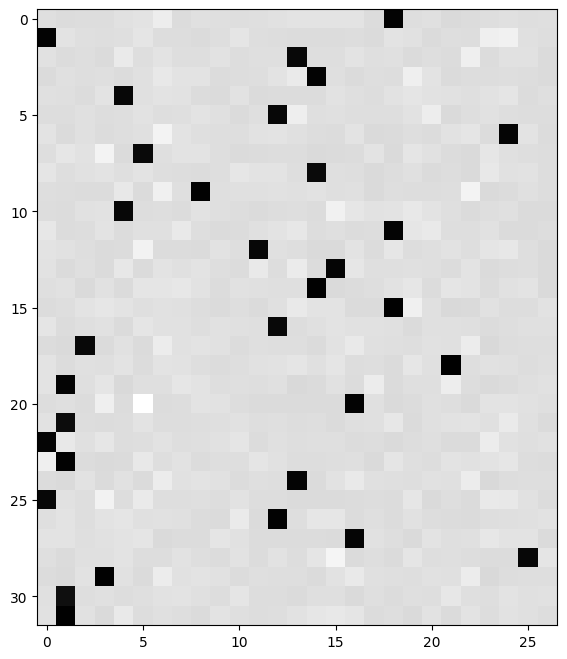

In [70]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

#This shows the amount at which a weight is mispredicting, is proportionate to the amount it gets pulled to the correct value

In [71]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [72]:
# Exercise 3: SOLUTION
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [73]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape


(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [74]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.6504
  10000/ 200000: 2.4826
  20000/ 200000: 2.4081
  30000/ 200000: 2.1171
  40000/ 200000: 2.0136
  50000/ 200000: 2.4699
  60000/ 200000: 2.3117
  70000/ 200000: 2.1242
  80000/ 200000: 1.9843
  90000/ 200000: 1.9823
 100000/ 200000: 2.4092
 110000/ 200000: 2.0681
 120000/ 200000: 2.2184
 130000/ 200000: 2.4171
 140000/ 200000: 2.2787
 150000/ 200000: 2.3758
 160000/ 200000: 2.1747
 170000/ 200000: 2.0310
 180000/ 200000: 2.3275
 190000/ 200000: 1.8797


In [75]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [76]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0711989402770996
val 2.1109797954559326


In [77]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzabelle.
khi.
miliathty.
salaysie.
mahnee.
delynn.
jarqui.
ner.
kia.
chaiiv.
kaleigh.
ham.
jord.
quint.
sulie.
alianni.
wate.
madiaryxiann.
eveigh.
brey.
